In [1]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install scikit-multilearn
!pip install datasets
!pip install peft
!pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 101.4 kB/s eta 0:00:000:00:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 946.3 kB/s eta 0:00:000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 743.6 kB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 63.3 kB/s eta 0:00:000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import warnings
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from skmultilearn.model_selection import iterative_train_test_split
from datasets import Dataset, DatasetDict
from pathlib import Path
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
sns.set_style("whitegrid")
warnings.simplefilter('ignore')

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Load Data

In [47]:
BASE_DIR = Path('Mistral7B_LoRA_class.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('matveeva/datasets')

FILE_NAME_QUAL = 'data_quality_estim_4classes.csv'

FILE_QUAL = DATA_DIR.joinpath(FILE_NAME_QUAL)

In [6]:
data_quality = pd.read_csv(FILE_QUAL)
data_quality.head(10)

,task,agg_label
0,able amaze fill glad stop daily fantastic move...,rather_bad
1,able amaze fill stop glad daily fantastic move...,rather_bad
2,able amaze fill stop glad daily fantastic move...,rather_bad
3,able amaze glad fill stop fantastic daily move...,bad
4,absolute church truth doug scripture symbol li...,rather_good
5,absolute church truth mission nasa doug mars e...,rather_bad
6,absolute mission church nasa mars earth truth ...,good
7,absolutely fast white rice service noodle terr...,rather_bad
8,absolutely fast white super service customer r...,good
9,absolutely grain experience soon there's proce...,bad


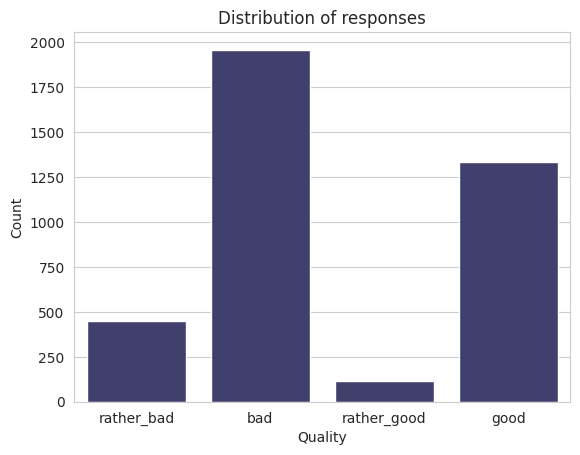

In [7]:
ax = sns.countplot(data=data_quality, x="agg_label", color="#3A3875")
ax.set_title("Distribution of responses")
ax.set(xlabel="Quality", ylabel="Count")
plt.show()

In [8]:
# Let's change the label encoding
label_lst = ["rather_bad", "bad", "rather_good", "good"]
for label in label_lst:
    data_quality[label] = np.zeros(data_quality.shape[0], dtype=int)

for ind, label in enumerate(data_quality["agg_label"]):
    data_quality.at[ind, label] = 1

data_quality.head(10)

,task,agg_label,rather_bad,bad,rather_good,good
0,able amaze fill glad stop daily fantastic move...,rather_bad,1,0,0,0
1,able amaze fill stop glad daily fantastic move...,rather_bad,1,0,0,0
2,able amaze fill stop glad daily fantastic move...,rather_bad,1,0,0,0
3,able amaze glad fill stop fantastic daily move...,bad,0,1,0,0
4,absolute church truth doug scripture symbol li...,rather_good,0,0,1,0
5,absolute church truth mission nasa doug mars e...,rather_bad,1,0,0,0
6,absolute mission church nasa mars earth truth ...,good,0,0,0,1
7,absolutely fast white rice service noodle terr...,rather_bad,1,0,0,0
8,absolutely fast white super service customer r...,good,0,0,0,1
9,absolutely grain experience soon there's proce...,bad,0,1,0,0


In [9]:
# reshape
idx = data_quality.index.tolist()
text = data_quality["task"]
labels = [[data_quality.iat[row_ind, 2], data_quality.iat[row_ind, 3], data_quality.iat[row_ind, 4], 
           data_quality.iat[row_ind, 5]] for row_ind in range(data_quality.shape[0])]

labels = np.array(labels, dtype=int)

x_test = text[:int(0.3 * data_quality.shape[0])]
y_test = labels[:int(0.3 * data_quality.shape[0])]

text = text[int(0.3 * data_quality.shape[0]):].reset_index()["task"]
labels = labels[int(0.3 * data_quality.shape[0]):]

dataset = [[text[i], labels[i]] for i in range(len(text))]

# set random seed
random.seed(0)
# shuffle data
random.shuffle(dataset)

text = np.array([dataset[i][0] for i in range(len(dataset))])
labels = np.array([dataset[i][1] for i in range(len(dataset))])
# text = np.array([dataset[i][0] for i in range(100)])
# labels = np.array([dataset[i][1] for i in range(100)])

# create label weights
label_weights = 1 - labels.sum(axis=0) / labels.sum()

# stratified train test split for multilabel datasets
row_ids = np.arange(len(labels))
train_idx, y_train, val_idx, y_val = iterative_train_test_split(row_ids[:,np.newaxis], labels, test_size = 0.2)
x_train = [text[i] for i in train_idx.flatten()]
x_val = [text[i] for i in val_idx.flatten()]

# create hf dataset
dataset = DatasetDict({
    'train': Dataset.from_dict({'text': x_train, 'labels': y_train}),
    'val': Dataset.from_dict({'text': x_val, 'labels': y_val})
})

In [10]:
len(x_test)

1158

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2163
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 540
    })
})

In [11]:
# preprocess dataset with tokenizer
def tokenize_examples(examples, tokenizer):
    tokenized_inputs = tokenizer(examples['text'])
    tokenized_inputs['labels'] = examples['labels']
    return tokenized_inputs

In [ ]:
# model name
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenized_ds = dataset.map(functools.partial(tokenize_examples, tokenizer=tokenizer), batched=True)
tokenized_ds = tokenized_ds.with_format('torch')

# qunatization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# lora config
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

# load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=labels.shape[1]
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.config.pad_token_id = tokenizer.pad_token_id


Map:   0%|          | 0/2163 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# define custom batch preprocessor
def collate_fn(batch, tokenizer):
    dict_keys = ['input_ids', 'attention_mask', 'labels']
    d = {k: [dic[k] for dic in batch] for k in dict_keys}
    d['input_ids'] = torch.nn.utils.rnn.pad_sequence(
        d['input_ids'], batch_first=True, padding_value=tokenizer.pad_token_id
    )
    d['attention_mask'] = torch.nn.utils.rnn.pad_sequence(
        d['attention_mask'], batch_first=True, padding_value=0
    )
    d['labels'] = torch.stack(d['labels'])
    return d

# define which metrics to compute for evaluation
def compute_metrics(p):
    predictions, labels = p
    f1_micro = f1_score(labels, predictions > 0, average = 'micro')
    f1_macro = f1_score(labels, predictions > 0, average = 'macro')
    f1_weighted = f1_score(labels, predictions > 0, average = 'weighted')
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [14]:
# create custom trainer class to be able to pass label weights and calculate mutilabel loss
class CustomTrainer(Trainer):

    def __init__(self, label_weights, **kwargs):
        super().__init__(**kwargs)
        self.label_weights = label_weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # compute custom loss
        loss = F.binary_cross_entropy_with_logits(logits, labels.to(torch.float32), pos_weight=self.label_weights)
        return (loss, outputs) if return_outputs else loss

In [16]:
# define training args
training_args = TrainingArguments(
    output_dir='multilabel_classification',
    learning_rate=10e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy ='steps',
    save_strategy = 'steps',
    load_best_model_at_end = True,
    logging_steps=100,
    lr_scheduler_type='constant_with_warmup'
)

# train
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['val'],
    tokenizer = tokenizer,
    data_collator = functools.partial(collate_fn, tokenizer=tokenizer),
    compute_metrics = compute_metrics,
    label_weights = torch.tensor(label_weights, device=model.device)
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted
100,1.407100,1.177198,0.000000,0.000000,0.000000
200,0.526400,0.797613,0.112963,0.050749,0.022931
300,0.569300,0.462209,0.000000,0.000000,0.000000
400,0.502900,0.392816,0.000000,0.000000,0.000000
500,0.463200,0.648588,0.427160,0.223476,0.387577
600,0.502600,0.583324,0.527778,0.172727,0.364646
700,1.503500,1.131474,0.000000,0.000000,0.000000
800,0.707300,0.436753,0.329630,0.123955,0.163438
900,0.461200,0.473628,0.329630,0.123955,0.163438
1000,0.424700,0.427812,0.000000,0.000000,0.000000


TrainOutput(global_step=10820, training_loss=0.4476313782707821, metrics={'train_runtime': 39221.9305, 'train_samples_per_second': 1.103, 'train_steps_per_second': 0.276, 'total_flos': 4.555464724063027e+16, 'train_loss': 0.4476313782707821, 'epoch': 20.0})

In [ ]:
vars(trainer)

In [17]:
loss_df = pd.DataFrame(trainer.state.log_history)

loss_lst = [item for item in loss_df["loss"] if not(pd.isnull(item))]
epoch_lst = loss_df["epoch"]
eval_loss_lst = [item for item in loss_df["eval_loss"] if not(pd.isnull(item))]

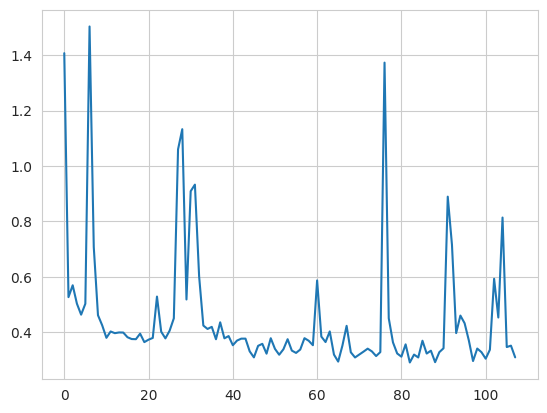

In [18]:
plt.plot(loss_lst)

In [37]:
models_dir = BASE_DIR.joinpath('matveeva/models')

peft_model_id = 'Mistral-7B_4bit_LoRA_class'

model_dir = models_dir.joinpath(peft_model_id)

In [23]:
# save model
trainer.model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('/matveeva/models/Mistral-7B_4bit_LoRA_class/tokenizer_config.json',
 '/matveeva/models/Mistral-7B_4bit_LoRA_class/special_tokens_map.json',
 '/matveeva/models/Mistral-7B_4bit_LoRA_class/tokenizer.json')

## Load for Testing

In [12]:
id2label = {
    0: "rather_bad",
    1: "bad",
    2: "rather_good",
    3: "good"
}
label2id = {
    "rather_bad": 0,
    "bad": 1,
    "rather_good": 2,
    "good": 3
}

In [13]:
from peft import PeftModel, PeftConfig  
from transformers import AutoModelForTokenClassification

models_dir = BASE_DIR.joinpath('matveeva/models')

peft_model_id = 'Mistral-7B_4bit_LoRA_class'

adapter_dir = models_dir.joinpath(peft_model_id)

config = PeftConfig.from_pretrained(adapter_dir)

inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=4, id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, adapter_dir)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-Instruct-v0.2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model_res = []
for test_sample in tqdm(x_test):
    inputs = tokenizer(test_sample, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    tokens = inputs.tokens()
    predictions = np.argmax(torch.nn.functional.softmax(logits))

    model_res.append(predictions.tolist())

100%|██████████████████████████████████████| 1158/1158 [52:26<00:00,  2.72s/it]


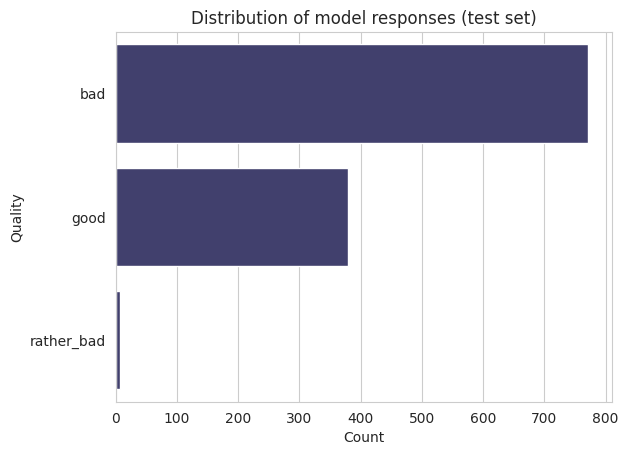

In [23]:
class_res = [id2label[class_id] for class_id in model_res]

ax = sns.countplot(data=class_res, color="#3A3875")
ax.set_title("Distribution of model responses (test set)")
ax.set(xlabel="Count", ylabel="Quality")
plt.show()

In [33]:
y_test = [np.argmax(sample) for sample in y_test]
y_test = [id2label[class_id] for class_id in y_test]

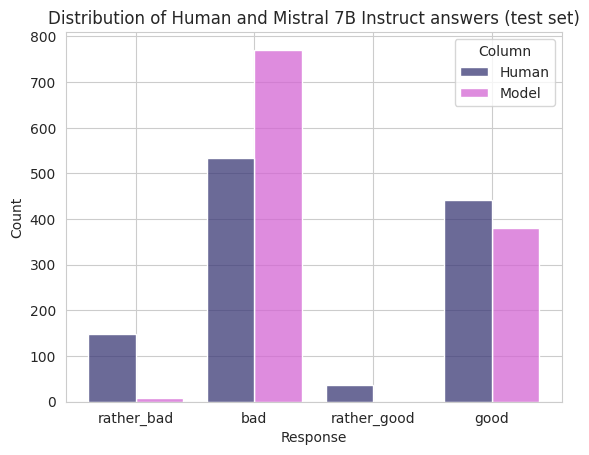

In [51]:
res_df = pd.DataFrame(data={
    "Human": y_test,
    "Model": class_res
})

df_long = res_df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

plt.title('Distribution of Human and Mistral 7B Instruct answers (test set)')
plt.show()

In [39]:
print("Accuracy:", round(accuracy_score(y_test, class_res), 4))
print("F1-score (weighted):", round(f1_score(y_test, class_res, average="weighted"), 4))

Accuracy: 0.6097
F1-score (weighted): 0.5556


In [74]:
res_df["Model"].value_counts()

Model
bad           771
good          380
rather_bad      7
Name: count, dtype: int64

## Inference on Entire Dataset

In [59]:
data_quality.head(10)

,task,agg_label,rather_bad,bad,rather_good,good
0,able amaze fill glad stop daily fantastic move...,rather_bad,1,0,0,0
1,able amaze fill stop glad daily fantastic move...,rather_bad,1,0,0,0
2,able amaze fill stop glad daily fantastic move...,rather_bad,1,0,0,0
3,able amaze glad fill stop fantastic daily move...,bad,0,1,0,0
4,absolute church truth doug scripture symbol li...,rather_good,0,0,1,0
5,absolute church truth mission nasa doug mars e...,rather_bad,1,0,0,0
6,absolute mission church nasa mars earth truth ...,good,0,0,0,1
7,absolutely fast white rice service noodle terr...,rather_bad,1,0,0,0
8,absolutely fast white super service customer r...,good,0,0,0,1
9,absolutely grain experience soon there's proce...,bad,0,1,0,0


In [69]:
model_res_inference = []
for sample in tqdm(data_quality["task"]):
    inputs = tokenizer(sample, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    tokens = inputs.tokens()
    predictions = np.argmax(torch.nn.functional.softmax(logits))    
    model_res_inference.append(predictions.tolist())

100%|████████████████████████████████████| 3861/3861 [2:57:02<00:00,  2.75s/it]


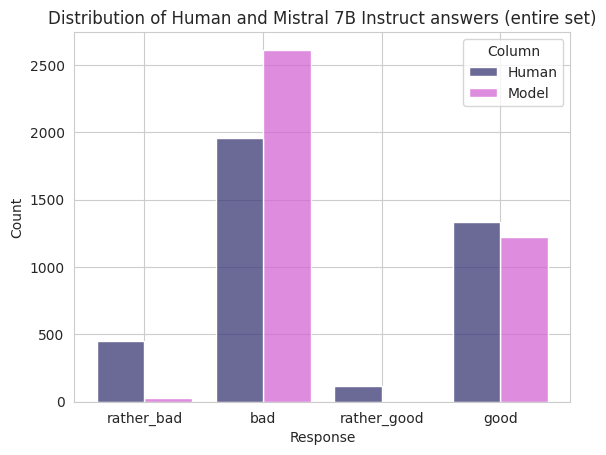

In [73]:
model_res_inference = [id2label[class_id] for class_id in model_res_inference]
inference_df = pd.DataFrame(data={
    "Human": data_quality["agg_label"],
    "Model": model_res_inference
})

df_long = inference_df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

plt.title('Distribution of Human and Mistral 7B Instruct answers (entire set)')
plt.show()

In [75]:
print("Accuracy:", round(accuracy_score(inference_df["Human"], inference_df["Model"]), 4))
print("F1-score (weighted):", round(f1_score(inference_df["Human"], inference_df["Model"], average="weighted"), 4))

Accuracy: 0.669
F1-score (weighted): 0.6156


In [77]:
inference_df["wordset"] = data_quality["task"]

inference_dir = BASE_DIR.joinpath('matveeva/results')
res_file = inference_dir.joinpath("text_coherence_mistral_7B_classification.csv")
inference_df.to_csv(res_file)